In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import distr
import common
import plots

In [12]:
import model_gaussian
model = model_gaussian

In [13]:
science_ndata = 20
science_theta_nature = 1.0

In [14]:
def collect_data(phi,ndata):
    print 'Taking Data...', science_theta_nature,phi,ndata
    return model.simulator(science_theta_nature,phi,ndata)

In [15]:
def calculate_posterior(prior,data,phi):
    print 'Calculate Posterior...'
    
    posterior = common.calculate_posterior(
                            prior,data,phi,
                            lnprob_args = model.details_likelihood_settings,
                            n_chainlen = 50
    )
    maximum_a_post = posterior.map(model.details_map_bins)
    
    print 'Best Theta: ', maximum_a_post
    return posterior, maximum_a_post

In [16]:
def design_next_experiment(prior):
    print 'Design Next Experiment...'
    
    eig_kwargs = {'emcee_kwargs' : {
                      'n_chainlen': 50,
                      'lnprob_args': model.details_likelihood_settings},
                  'sim_n_data': science_ndata,
                  'map_bins': model.details_map_bins}
    res_gp   = common.design_next_experiment_bayesopt(prior,model.phi_range,eig_kwargs, n_totalcalls = 7)
    res_next_phi = res_gp[0].x[0]
    
    print 'Next Phi: ', res_next_phi
    return res_gp,res_next_phi

In [17]:
import science_loop_widget
import yadage_widget
from ipywidgets import widgets
science_wdg = science_loop_widget.loopwidget()
collect_ui  = yadage_widget.WorkflowWidget(None)
widgets.HBox([science_wdg.view,collect_ui])

# Running the Science Loop

Taking Data... 1.0 -1 20
Calculate Posterior...
Best Theta:  0.7
Design Next Experiment...
2017-06-09 00:41:28.606660 EIG via 4 parallel experiments with [theta,phi] 0.7 5.80217903408
2017-06-09 00:41:42.370986 EIG via 4 parallel experiments with [theta,phi] 0.7 3.28339349505
2017-06-09 00:41:55.439255 EIG via 4 parallel experiments with [theta,phi] 0.7 5.83610615979
2017-06-09 00:42:08.800886 EIG via 4 parallel experiments with [theta,phi] 0.7 4.28889596205
2017-06-09 00:42:22.456255 EIG via 4 parallel experiments with [theta,phi] 0.7 4.18637294758
2017-06-09 00:42:35.937568 EIG via 4 parallel experiments with [theta,phi] 0.7 4.38106621125
2017-06-09 00:42:50.797329 EIG via 4 parallel experiments with [theta,phi] 0.7 4.32587135529
Next Phi:  4.28889596205


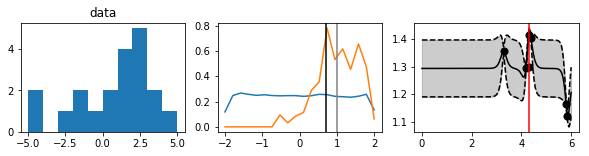

Taking Data... 1.0 4.28889596205 20
Calculate Posterior...
Best Theta:  0.9
Design Next Experiment...
2017-06-09 00:43:05.093579 EIG via 4 parallel experiments with [theta,phi] 0.9 5.80217903408
2017-06-09 00:43:18.053911 EIG via 4 parallel experiments with [theta,phi] 0.9 3.28339349505
2017-06-09 00:43:30.409672 EIG via 4 parallel experiments with [theta,phi] 0.9 5.83610615979
2017-06-09 00:43:43.671052 EIG via 4 parallel experiments with [theta,phi] 0.9 4.28889596205
2017-06-09 00:43:56.935018 EIG via 4 parallel experiments with [theta,phi] 0.9 4.18637294758
2017-06-09 00:44:11.394175 EIG via 4 parallel experiments with [theta,phi] 0.9 1.36324219218
2017-06-09 00:44:24.886862 EIG via 4 parallel experiments with [theta,phi] 0.9 3.35441769557
Next Phi:  3.35441769557


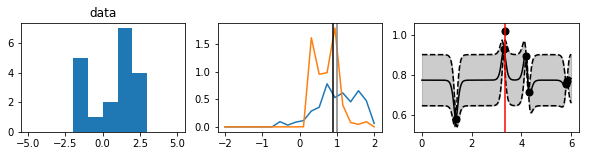

In [19]:
# initial experimental settings and uninformative prior
loop_phi = -1
loop_prior = distr.Distribution('prior',range = model.theta_range)

science_history = []
n_science_iterations = 2
for i in range(n_science_iterations):
    plt.clf()

    fig,axarr = plt.subplots(1,3)
    fig.set_size_inches(10,2)
    axarr[0].set_title('data')
    
    ## 1. Perform Experiment
    science_wdg.toggle(0)
    loop_data = collect_data(loop_phi,science_ndata)
    plots.plot_data(loop_data,model.data_range, ax = axarr[0])

    ## 2. Calculate the Posterior
    science_wdg.toggle(1)
    loop_posterior, loop_best_theta = calculate_posterior(loop_prior,loop_data,loop_phi)
    plots.plot_posterior(loop_prior,loop_posterior,loop_best_theta,science_theta_nature, model.theta_range, ax = axarr[1])

    ## 3. Design Next Experiment
    science_wdg.toggle(2)
    loop_res_gp, loop_next_phi = design_next_experiment(loop_posterior)

    plots.plot_bayes(loop_res_gp,phi_range = model.phi_range, ax = axarr[2])
    plt.show()


    science_history.append([loop_data,loop_prior,loop_posterior,loop_best_theta,science_theta_nature,loop_res_gp])
    
    ## 5. Update our Prior and experimental settings
    loop_prior = loop_posterior
    loop_phi   = loop_next_phi